In [37]:
from spenpy.spen import spen
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.utils as vutils

In [38]:
path = "spenpy/data/brain.png"
img = Image.open(path)
to_tensor = T.ToTensor()
img = to_tensor(img)[0] # our image is grayscale, so we take the first channel

print(img.shape)

torch.Size([256, 256])


In [39]:
InvA, AFinal = spen().get_InvA() # (256, 256) (256, 256)

final_rxyacq_ROFFT = spen().sim(img.unsqueeze(0)) # (1, 256, 256)
phase_map = spen().get_phase_map(img.unsqueeze(0)) # (1, 128, 256)

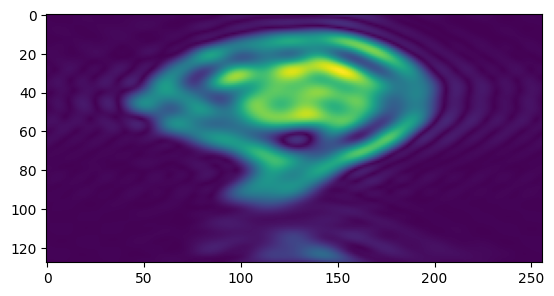

In [40]:
plt.imshow(phase_map.abs()[0])

In [41]:
EvenDataROFFT = final_rxyacq_ROFFT[:, 1::2, :].clone() # (1, 128, 256)
EvenDataROFFT = EvenDataROFFT * torch.exp(-1j *phase_map)
FinalryxacqROFFTCorr = final_rxyacq_ROFFT.clone() # (1, 256, 256)
FinalryxacqROFFTCorr[:, 1::2, :] = EvenDataROFFT

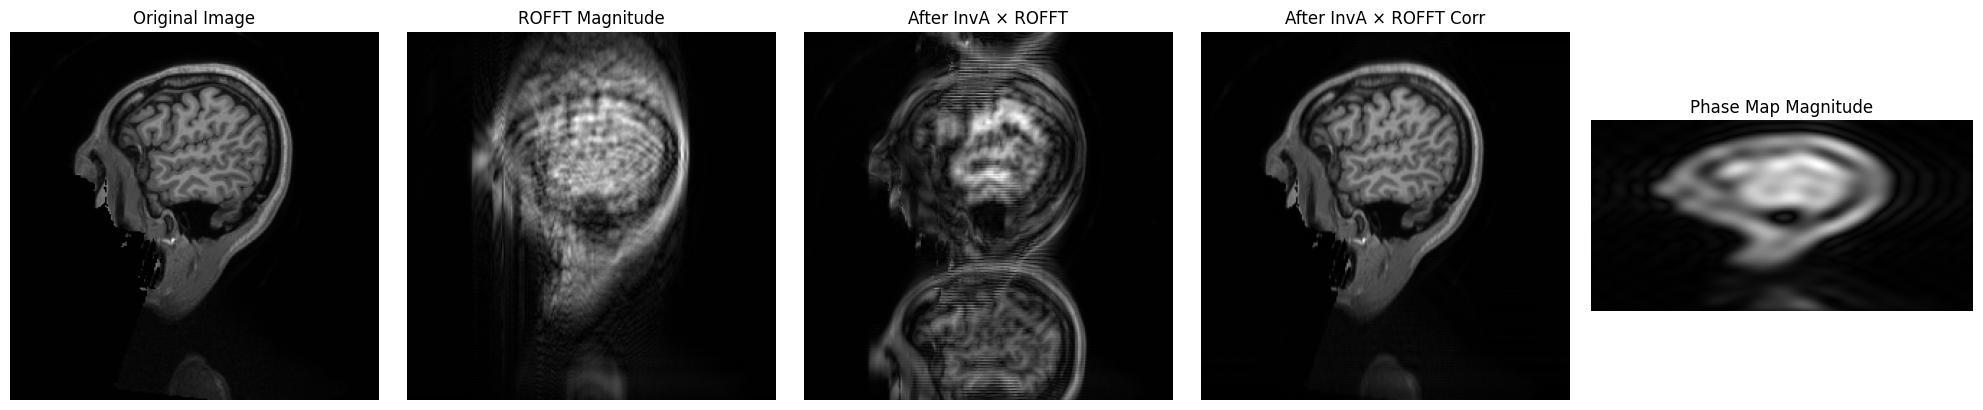

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(img.numpy(), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(torch.abs(final_rxyacq_ROFFT)[0].numpy(), cmap='gray')
axs[1].set_title("ROFFT Magnitude")
axs[1].axis("off")

axs[2].imshow(torch.abs(torch.matmul(InvA, final_rxyacq_ROFFT)[0]).numpy(), cmap='gray')
axs[2].set_title("After InvA × ROFFT")
axs[2].axis("off")

axs[3].imshow(torch.abs(torch.matmul(InvA, FinalryxacqROFFTCorr)[0]).numpy(), cmap='gray')
axs[3].set_title("After InvA × ROFFT Corr")
axs[3].axis("off")

axs[4].imshow(phase_map.abs()[0].numpy(), cmap='gray')
axs[4].set_title("Phase Map Magnitude")
axs[4].axis("off")

plt.tight_layout()
plt.show()

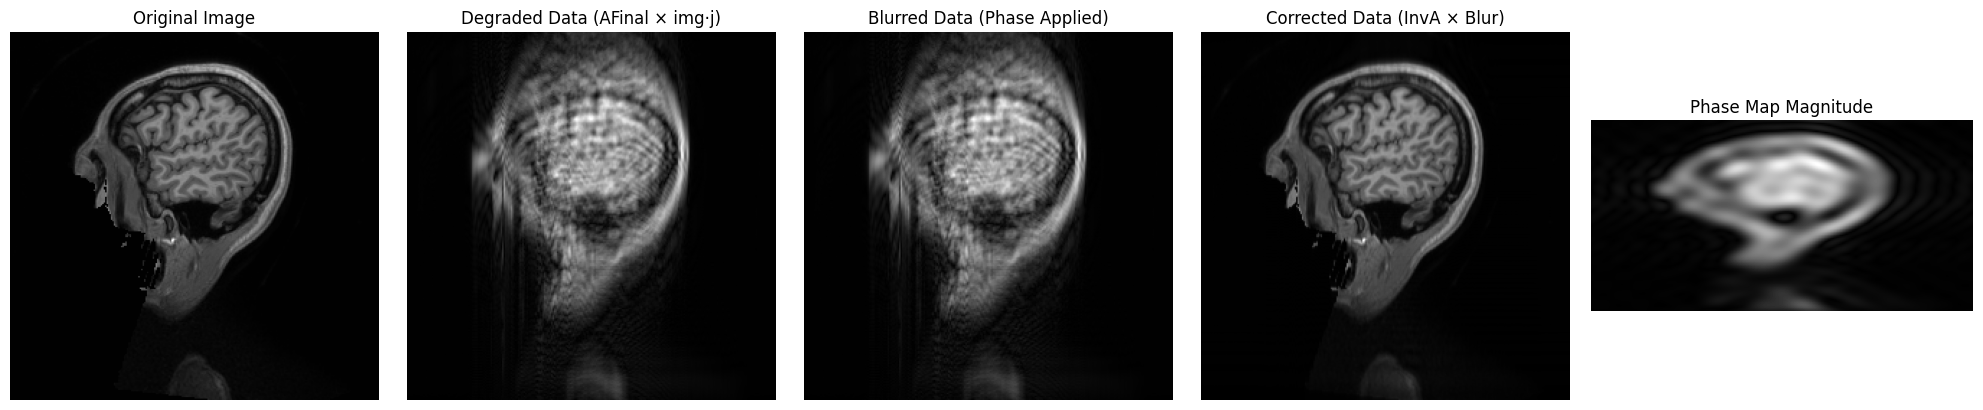

In [43]:
degraded_data = torch.matmul(AFinal, img.unsqueeze(0)*1j)

blur_data = degraded_data.clone()
blur_data[:, 1::2, :] = degraded_data[:, 1::2, :] * torch.exp(1j * phase_map)

corr_data = blur_data
corr_data[:, 1::2, :] = corr_data[:, 1::2, :] * torch.exp(-1j * phase_map)
corr_data = torch.matmul(InvA, blur_data).clone()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(img.numpy(), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(degraded_data[0].abs().numpy(), cmap='gray')
axs[1].set_title("Degraded Data (AFinal × img·j)")
axs[1].axis("off")

axs[2].imshow(blur_data.abs()[0].numpy(), cmap='gray')
axs[2].set_title("Blurred Data (Phase Applied)")
axs[2].axis("off")

axs[3].imshow(torch.abs(corr_data)[0].numpy(), cmap='gray')
axs[3].set_title("Corrected Data (InvA × Blur)")
axs[3].axis("off")

axs[4].imshow(phase_map.abs()[0].numpy(), cmap='gray')
axs[4].set_title("Phase Map Magnitude")
axs[4].axis("off")

plt.tight_layout()
plt.show()


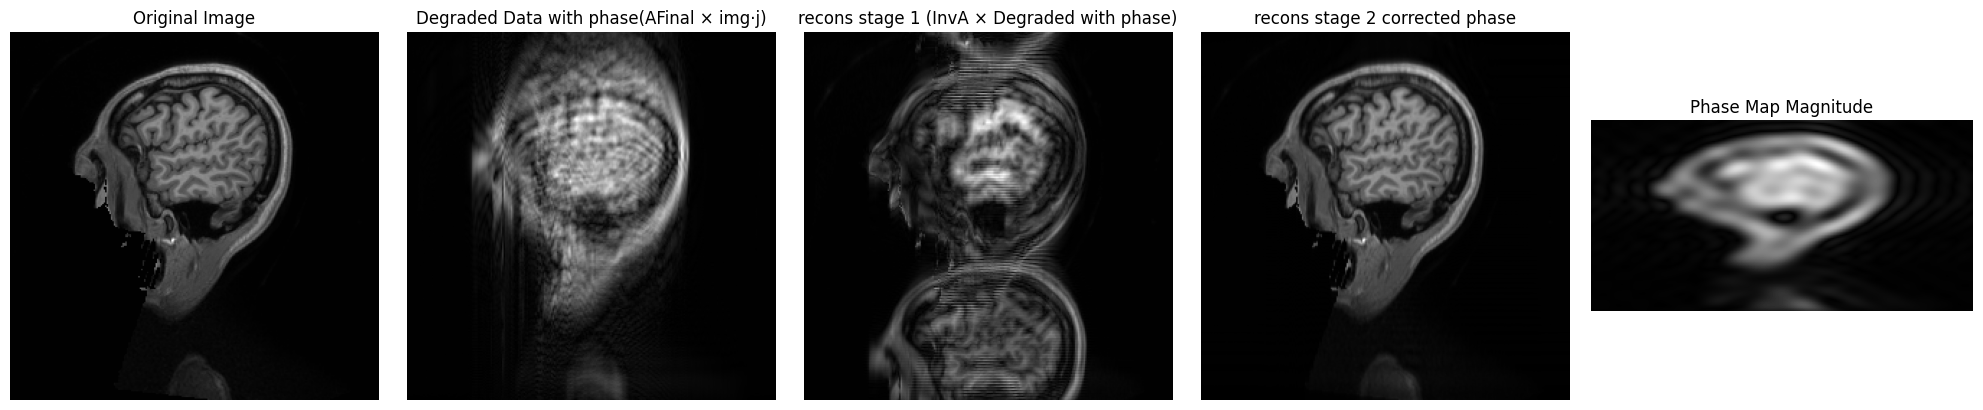

In [ ]:
degraded_data = torch.matmul(AFinal, img.unsqueeze(0)*1j)

# Stage 1: with phase
degraded_data_with_phase = degraded_data.clone()
degraded_data_with_phase[:, 1::2, :] *= torch.exp(1j * phase_map)


recons_stage_1 = degraded_data_with_phase.clone()
recons_stage_1 = torch.matmul(InvA, recons_stage_1)


# Stage 2: phase correction in k-space
corr_kspace = degraded_data_with_phase.clone()
corr_kspace[:, 1::2, :] *= torch.exp(-1j * phase_map)
recons_stage_2 = torch.matmul(InvA, corr_kspace)



fig, axs = plt.subplots(1, 5, figsize=(20, 4))

axs[0].imshow(img.numpy(), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(degraded_data_with_phase[0].abs().numpy(), cmap='gray')
axs[1].set_title("Degraded Data with phase(AFinal × img·j)")
axs[1].axis("off")

axs[2].imshow(recons_stage_1[0].abs().numpy(), cmap='gray')
axs[2].set_title("recons stage 1 (InvA × Degraded with phase)")
axs[2].axis("off")

axs[3].imshow(recons_stage_2[0].abs().numpy(), cmap='gray')
axs[3].set_title("recons stage 2 corrected phase")
axs[3].axis("off")

axs[4].imshow(phase_map.abs()[0].numpy(), cmap='gray')
axs[4].set_title("Phase Map Magnitude")
axs[4].axis("off")

plt.tight_layout()
plt.show()
